In [1]:
import sys
import redis as r
import pandas as pd
import pandasql as ps
from datetime import datetime
import time
import tqdm
import os
import pathlib
import shutil
import gzip
import seaborn as sns

In [2]:
# test
for i in tqdm.tqdm(range(5)):
    time.sleep(0.5)

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


In [44]:
mode="prod" # test, prod
dbname="janus11-staging"
hostname="redis-10111.snc1.raas-shared3-staging.grpn"
port=10111
db=0
scan_buffer_size=500_000
dbpath=f'/home/ksatyamurthy/janus/{dbname}'
pathlib.Path(dbpath).mkdir(parents=True, exist_ok=True) 


In [4]:
def t(input):
    print(input + " " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


In [5]:
def gzip_file(in_file):
    in_data = open(in_file, "rb").read()
    out_gz = in_file + ".gz"
    gzf = gzip.open(out_gz, "wb")
    gzf.write(in_data)
    gzf.close()
    os.unlink(in_file)
    
def guzip_file(in_file):
    with gzip.open(in_file + 'gzip', 'rb') as f_in:
        with open(in_file.replace('.gz',''), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            os.unlink(in_file)

In [6]:
def scan_keys(hostname,portno,db,scancount):
    keys_names=[]
    keys_ttls=[]
    keys_idletime=[]
    rc=r.Redis(host=hostname,port=portno,db=db)
    print("Connected to redis")
    total_no_of_keys=rc.info()['db0']['keys']
    tmp=rc.scan(0,count=scancount)
    tmp_processed_keys=0
    while tmp[0] != 0:
        tmp_processed_keys=tmp_processed_keys+len(tmp[1])
        vartime=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        tmp_ppercent=f'{100*tmp_processed_keys/total_no_of_keys:.2f}'.rjust(6,' ')
        print(f"  At {vartime} scanned: {tmp_processed_keys:>10} which is {tmp_ppercent}% of keys ({total_no_of_keys})")
        for key in tqdm.tqdm(range(len(tmp[1]))):
            keyname=tmp[1][key].decode("utf-8")
            keys_names.append(keyname)
            keys_ttls.append(rc.ttl(keyname))
            keys_idletime.append(rc.object("idletime",keyname))
        tmp=rc.scan(tmp[0],count=scancount)
    print("Scanning completed")
    data_tuples=list(zip(keys_names,keys_ttls,keys_idletime))
    keys_info=pd.DataFrame(data_tuples, columns=['name','ttl','idletime'])
    return keys_info


In [7]:
def scankeys_and_apply_expire(hostname,portno,db,keylist,timeseconds):
    if(len(keylist)==0):
        return None
    keys_errorcode=[]
    ttl_before=[]
    memory_usage_bytes=[]
    rc=r.Redis(host=hostname,port=portno,db=db)
    for key in tqdm.tqdm(keylist):
        ttlvalue=rc.ttl(key)
        ttl_before.append(ttlvalue)
        memory_usage_bytes.append(rc.memory_usage(key))
        if(ttlvalue >= timeseconds):
            if(mode == "prod"):
                errcode=rc.expire(key,timeseconds)
            elif(mode == "test"):
                errcode=1                                                 
            keys_errorcode.append(errcode)
        elif(ttlvalue == -1):
            if(mode == "prod"):
                errcode=rc.expire(key,timeseconds)
            elif(mode == "test"):
                errcode=0                          
            keys_errorcode.append(errcode)
        elif(ttlvalue == -2):
            keys_errorcode.append(-2)
        elif(ttlvalue < timeseconds):
            keys_errorcode.append(-3)
        else:
            keys_errorcode.append(-4)
    data_tuples=list(zip(keylist,ttl_before,memory_usage_bytes,keys_errorcode))
    keys_info=pd.DataFrame(data_tuples, columns=['name','ttl_before','memory_usage_bytes','expire_status'])
    return keys_info


In [18]:
def scankeys_and_apply_delete(hostname,portno,db,keylist):
    keys_errorcode=[]
    ttl_before=[]
    memory_usage_bytes=[]
    if(len(keylist)==0):
        data_tuples=list(zip(keylist,ttl_before,memory_usage_bytes,keys_errorcode))
        keys_info=pd.DataFrame(data_tuples, columns=['name','ttl_before','memory_usage_bytes','delete_status'])
        return keys_info
    rc=r.Redis(host=hostname,port=portno,db=db)
    for key in tqdm.tqdm(keylist):
        ttlvalue=rc.ttl(key)
        ttl_before.append(ttlvalue)
        memory_usage_bytes.append(rc.memory_usage(key))
        if(mode == "prod"):
            errcode=rc.unlink(key)
        elif(mode == "test"):
            errcode=None
        keys_errorcode.append(errcode)
    data_tuples=list(zip(keylist,ttl_before,memory_usage_bytes,keys_errorcode))
    keys_info=pd.DataFrame(data_tuples, columns=['name','ttl_before','memory_usage_bytes','delete_status'])
    return keys_info


In [9]:
keynames=scan_keys(hostname,port,db,scan_buffer_size)

Connected to redis


  0%|          | 137/499996 [00:00<06:04, 1369.75it/s]

  At 2021-04-02 15:58:25 scanned:     499996 which is  25.99% of keys (1924047)


  0%|          | 139/450080 [00:00<05:26, 1379.50it/s]

  At 2021-04-02 16:04:39 scanned:     950076 which is  49.38% of keys (1924047)


  0%|          | 133/499502 [00:00<06:16, 1327.67it/s]

  At 2021-04-02 16:10:20 scanned:    1449578 which is  75.34% of keys (1924047)


100%|██████████| 499502/499502 [06:14<00:00, 1332.19it/s]


Scanning completed


In [10]:
keynames.shape

(1449578, 3)

In [11]:
keynames.to_csv(f'{dbpath}/keynames.csv',index=False, header=True)
gzip_file(f'{dbpath}/keynames.csv')
#guzip_file(f'{dbpath}/keynames.csv')
#keynames=pd.read_csv(f'{dbpath}/keynames.csv')

In [45]:
# Logic 1:  
# All standalone sales keys without views can be deleted

sales_standalone=ps.sqldf("""
with k1(name,sale) as (select name, substr(name,0,instr(name,'|sales')) sale from keynames where name like '%sales'),
k2(name,view) as (select name, substr(name,0,instr(name,'|views')) view from keynames where name like '%views')

select a.name from 
k1 as a left join k2 as b
on a.sale=b.view where b.name is null
group by 1
""")

In [46]:
# 2000 it/s is normal 
sales_standalone_delete_status=scankeys_and_apply_delete(hostname,port,db,list(sales_standalone['name']))

100%|██████████| 120647/120647 [02:18<00:00, 871.05it/s]


In [47]:
sales_standalone_delete_status.head()

,name,ttl_before,memory_usage_bytes,delete_status
0,user|00007f4e-1cf6-11eb-999f-0242ac120002|sales,-1,329.0,1
1,user|00008d90-e687-11ea-8b31-0242ac120002|sales,-1,353.0,1
2,user|0001889a-25fa-11e2-9703-00259069d5fe|sales,-1,601.0,1
3,user|0002002e-60e2-11ea-9be7-0242ac120002|sales,-1,348.0,1
4,user|0002a5ec-3d20-11e9-904a-0242ac110002|sales,30844047,483.0,1


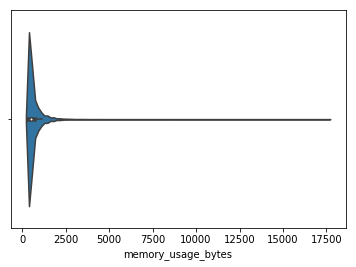

In [48]:
#sales_standalone_delete_status.describe()

ax = sns.violinplot(x=sales_standalone_delete_status["memory_usage_bytes"])

In [49]:
sales_standalone_delete_status.to_csv(f'{dbpath}/sales_standalone_delete_status.csv',index=False, header=True)
gzip_file(f'{dbpath}/sales_standalone_delete_status.csv')
#guzip_file(f'{dbpath}/sales_standalone_delete_status.csv')
#keynames=pd.read_csv(f'{dbpath}/sales_standalone_delete_status.csv')

In [50]:
#sales_stan"dalone_delete_status.head(10)
if(mode == "test"):
    print(sales_standalone_delete_status.query('delete_status not in [@pd.NaT] ')['name'].count())
elif(mode == "prod"):
    print(sales_standalone_delete_status.query('delete_status == 1 ')['name'].count())

119704


In [51]:
if(mode == "test"):
    print(sales_standalone_delete_status.query('delete_status not in [@pd.NaT] ')['memory_usage_bytes'].sum()/(1024**2))
elif(mode == "prod"):
    print(sales_standalone_delete_status.query('delete_status == 1 ')['memory_usage_bytes'].sum()/(1024**2))

69.61299896240234


In [52]:
# Logic 2: 

rconn=r.Redis(host=hostname,port=port,db=db)
sales_unlink=ps.sqldf("select replace(name,'views','sales') name from keynames where idletime > 30*24*60*60*1.0 and name like '%views'")
df_join=pd.merge(sales_unlink,keynames,how="inner")
print(f"Delete sales...")



Delete sales...


In [53]:
delete_status=scankeys_and_apply_delete(hostname,port,db,list(df_join['name']))


In [54]:
delete_status.to_csv(f'{dbpath}/delete_status.csv',index=False, header=True)
gzip_file(f'{dbpath}/delete_status.csv')
#guzip_file(f'{dbpath}/delete_status.csv')
#keynames=pd.read_csv(f'{dbpath}/delete_status.csv')

In [55]:
# Logic 3:

views_gt30days=ps.sqldf("select * from keynames where idletime > 30*24*60*60*1.0 and name like '%views'")
# set expire to 21 days when the views are not access > 1 month
print(f"Applying  21 days expire...")
  # 52 mins ((7466595, 3))


Applying  21 days expire...


In [56]:
# 2000 it/s is normal else it is slow

view_expire_status=scankeys_and_apply_expire(hostname,port,db,list(views_gt30days['name']),21*24*60*60)



100%|██████████| 84269/84269 [01:30<00:00, 934.98it/s] 


In [57]:
view_expire_status.head()

,name,ttl_before,memory_usage_bytes,expire_status
0,user|d150d354-2412-11e2-86db-00259069d5fe|views,26182357,588.0,True
1,user|8cbf32c8-1be2-11eb-a2dd-0242ac120002|views,26948577,518.0,True
2,user|709a9bdc-1a0d-11ea-92dd-0242ac120002|views,27247177,1915.0,True
3,user|5b6696fe-f977-4dd0-9cf0-75755c0e5883|views,27177217,1133.0,True
4,user|db83a1ee-238b-11e2-92da-00259069d5fe|views,27086557,736.0,True


In [58]:
view_expire_status.to_csv(f'{dbpath}/view_expire_status.csv',index=False, header=True)
gzip_file(f'{dbpath}/view_expire_status.csv')
#guzip_file(f'{dbpath}/view_expire_status.csv')
#keynames=pd.read_csv(f'{dbpath}/view_expire_status.csv')

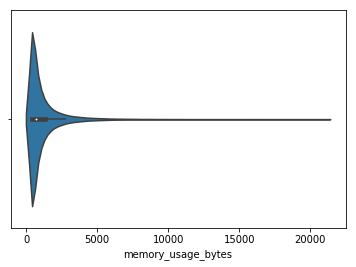

In [59]:
ax = sns.violinplot(x=view_expire_status["memory_usage_bytes"])

In [60]:
view_expire_status['expire_status'].value_counts()

True    83108
-2       1153
-3          8
Name: expire_status, dtype: int64

In [61]:
view_expire_status.query('expire_status == 1')['memory_usage_bytes'].sum()/(1024**2)

95.69645595550537

In [62]:
# Logic 4:
sales_remaining=ps.sqldf("select * from keynames where name like '%sales'")
print(f"Applying 365 days expire...")




Applying 365 days expire...


In [63]:
sales_remaining_expire_status=scankeys_and_apply_expire(hostname,port,db,list(sales_remaining['name']),365*24*60*60)

100%|██████████| 120647/120647 [01:26<00:00, 1400.26it/s]


In [64]:
sales_remaining_expire_status.to_csv(f'{dbpath}/sales_remaining_expire_status.csv',index=False, header=True)
gzip_file(f'{dbpath}/sales_remaining_expire_status.csv')
#guzip_file(f'{dbpath}/sales_remaining_expire_status.csv')
#keynames=pd.read_csv(f'{dbpath}/sales_remaining_expire_status.csv')

In [65]:
sales_remaining_expire_status['expire_status'].value_counts()


-2    120626
-3        21
Name: expire_status, dtype: int64

In [74]:
if(mode == "test"):
    print(sales_remaining_expire_status.query('expire_status == 0')['memory_usage_bytes'].sum()/(1024**2))
elif(mode == "prod"):
    print(sales_remaining_expire_status.query('expire_status == 1')['memory_usage_bytes'].sum()/(1024**2))
    


0.0


In [78]:
if(mode == "test"):
    views_new_ttl        =ps.sqldf(' select count(*) cnt from view_expire_status            where (expire_status like "0%" or expire_status like "1%"  ) ')['cnt'][0]
    views_ttl_untouched  =ps.sqldf(' select count(*) cnt from view_expire_status            where expire_status like "%-3%"')['cnt'][0]
    sales_new_ttl        =ps.sqldf(' select count(*) cnt from sales_remaining_expire_status where (expire_status like "0%" or expire_status like "1%"  )')['cnt'][0]
    sales_ttl_untouched  =ps.sqldf(' select count(*) cnt from sales_remaining_expire_status where expire_status like "%-3%"')['cnt'][0]
    totalno_keys         =keynames.shape[0]
    sales_del_memory_saved=sales_standalone_delete_status.query('delete_status not in [@pd.NaT] ')['memory_usage_bytes'].sum()/(1024**2)
    views_new_memory_saved=ps.sqldf(' select sum(memory_usage_bytes)/(1024*1024) size_mb from view_expire_status  where (expire_status like "0%" or expire_status like "1%"  )')['size_mb'][0]
    sales_new_memory_saved=ps.sqldf(' select sum(memory_usage_bytes)/(1024*1024) size_mb from sales_remaining_expire_status  where (expire_status like "0%" or expire_status like "1%"  )')['size_mb'][0]
    db_size=rconn.info()['used_memory']/(1024*1024)
    db_size_human=rconn.info ()['used_memory_human']
    sales_del=sales_standalone_delete_status.query('delete_status not in [@pd.NaT] ')['name'].count()
elif(mode == "prod"):
    views_new_ttl        =ps.sqldf(' select count(*) cnt from view_expire_status            where expire_status like "1%"')['cnt'][0]
    views_ttl_untouched  =ps.sqldf(' select count(*) cnt from view_expire_status            where expire_status like "%-3%"')['cnt'][0]
    sales_new_ttl        =ps.sqldf(' select count(*) cnt from sales_remaining_expire_status where expire_status like "1%"')['cnt'][0]
    sales_ttl_untouched  =ps.sqldf(' select count(*) cnt from sales_remaining_expire_status where expire_status like "%-3%"')['cnt'][0]
    totalno_keys         =keynames.shape[0]
    sales_del_memory_saved=sales_standalone_delete_status.query('delete_status == 1 ')['memory_usage_bytes'].sum()/(1024**2)
    views_new_memory_saved=ps.sqldf(' select sum(memory_usage_bytes)/(1024*1024) size_mb from view_expire_status  where expire_status like "1%"')['size_mb'][0]
    sales_new_memory_saved=ps.sqldf(' select sum(memory_usage_bytes)/(1024*1024) size_mb from sales_remaining_expire_status  where expire_status like "1%"')['size_mb'][0]
    db_size=rconn.info()['used_memory']/(1024*1024)
    db_size_human=rconn.info ()['used_memory_human']
    sales_del=sales_standalone_delete_status.query('delete_status == 1 ')['name'].count()
    
if(sales_new_memory_saved is None):
    sales_new_memory_saved=0

In [79]:
print(f'DB name  : {dbname}')
print(f'Endpoint : {hostname}')
print(f'Total no of keys: {totalno_keys}')
print(f'Sales deleted (logic 1 )  : {sales_del}')
print(f'Sales deleted (logic 2 ) : {df_join.shape[0]}')
print(f'Views new ttl of 21 days  : {views_new_ttl}   Percent:{100.0*views_new_ttl/totalno_keys:.2f}')
print(f'Views untouched has <  21 days ttl  : {views_ttl_untouched}  Percent:{100.0*views_ttl_untouched/totalno_keys:.2f}')
print(f'Sales new ttl 365 days  : {sales_new_ttl}  Percent:{100.0*sales_new_ttl/totalno_keys:.2f}')
print(f'Sales untouched has < 365 days ttl  : {sales_ttl_untouched}  Percent:{100.0*sales_ttl_untouched/totalno_keys:.2f}')
print(f'Memory may be saved in delete sales: {sales_del_memory_saved:.2f} MB Percent:{100.0*sales_del_memory_saved/db_size:.2f} ')
print(f'Memory may be saved in  21 days: {views_new_memory_saved:.2f} MB Percent:{100.0*views_new_memory_saved/db_size:.2f} ')
print(f'Memory may be saved in 365 days: {sales_new_memory_saved} MB Percent:{100.0*sales_new_memory_saved/db_size} ')
print(f'Size of DB: {db_size_human}B ')


DB name  : janus11-staging
Endpoint : redis-10111.snc1.raas-shared3-staging.grpn
Total no of keys: 1449578
Sales deleted (logic 1 )  : 119704
Sales deleted (logic 2 ) : 0
Views new ttl of 21 days  : 83108   Percent:5.73
Views untouched has <  21 days ttl  : 8  Percent:0.00
Sales new ttl 365 days  : 0  Percent:0.00
Sales untouched has < 365 days ttl  : 21  Percent:0.00
Memory may be saved in delete sales: 69.61 MB Percent:2.47 
Memory may be saved in  21 days: 95.70 MB Percent:3.40 
Memory may be saved in 365 days: 0 MB Percent:0.0 
Size of DB: 2.74GB 
